In [99]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import numpy
import iris
import iris.coord_categorisation
import iris.plot as iplt
import matplotlib.pyplot as plt

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import convenient_universal as uconv

In [100]:
def annual_mean(cube):
    """Calculate the annual mean timeseries"""
    
    iris.coord_categorisation.add_year(cube, 'time')
    cube = cube.aggregated_by(['year'], iris.analysis.MEAN)
    
    return cube

## netTOA

1. Read the data

In [101]:
rsdt_file = '/g/data/p66/CMIP6/APP_publishable/CMIP6/CMIP/CSIRO-ARCCSS-BoM/ACCESS-CM2/piControl/r1i1p1f1/Amon/rsdt/gn/v20190909/rsdt_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-124912.nc'
rsut_file = '/g/data/p66/CMIP6/APP_publishable/CMIP6/CMIP/CSIRO-ARCCSS-BoM/ACCESS-CM2/piControl/r1i1p1f1/Amon/rsut/gn/v20190909/rsut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-124912.nc'
rlut_file = '/g/data/p66/CMIP6/APP_publishable/CMIP6/CMIP/CSIRO-ARCCSS-BoM/ACCESS-CM2/piControl/r1i1p1f1/Amon/rlut/gn/v20190909/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-124912.nc'

In [102]:
rsdt_cube = iris.load_cube(rsdt_file, 'toa_incoming_shortwave_flux')
rsut_cube = iris.load_cube(rsut_file, 'toa_outgoing_shortwave_flux')
rlut_cube = iris.load_cube(rlut_file, 'toa_outgoing_longwave_flux')

2. Calculate the annual mean

In [103]:
rsdt_cube = annual_mean(rsdt_cube)
rsut_cube = annual_mean(rsut_cube)
rlut_cube = annual_mean(rlut_cube)

3. Convert units from $W m^{-2}$ to $W$

In [104]:
areacella_file = '/g/data/p66/CMIP6/APP_publishable/CMIP6/CMIP/CSIRO-ARCCSS-BoM/ACCESS-CM2/piControl/r1i1p1f1/fx/areacella/gn/v20190909/areacella_fx_ACCESS-CM2_piControl_r1i1p1f1_gn.nc'
areacella_cube = iris.load_cube(areacella_file, 'cell_area')
area_array = uconv.broadcast_array(areacella_cube.data, [1, areacella_cube.ndim], rsdt_cube.shape)

In [105]:
rsdt_cube.data = rsdt_cube.data * area_array
rsut_cube.data = rsut_cube.data * area_array
rlut_cube.data = rlut_cube.data * area_array

rsdt_cube.units = str(rsdt_cube.units).replace('m-2', '')
rsut_cube.units = str(rsut_cube.units).replace('m-2', '')
rlut_cube.units = str(rlut_cube.units).replace('m-2', '')

4. Calculate the global total flux

In [106]:
rsdt_cube = rsdt_cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM)
rsut_cube = rsut_cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM)
rlut_cube = rlut_cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM)

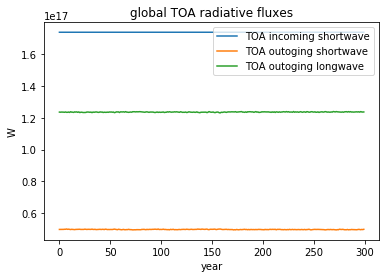

In [107]:
plt.plot(rsdt_cube.data, label='TOA incoming shortwave')
plt.plot(rsut_cube.data, label='TOA outoging shortwave')
plt.plot(rlut_cube.data, label='TOA outoging longwave')
plt.xlabel('year')
plt.ylabel(rsdt_cube.units)
plt.legend()
plt.title('global TOA radiative fluxes')
plt.show()

5. Calculate the net TOA flux

In [108]:
netTOA = rsdt_cube.data - rlut_cube.data - rsut_cube.data

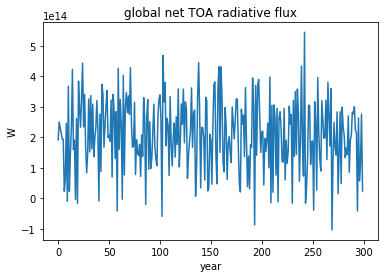

In [109]:
plt.plot(netTOA)
plt.xlabel('year')
plt.ylabel('W')
plt.title('global net TOA radiative flux')
plt.show()

6. Convert units from W to J

In [110]:
time_coord = rsdt_cube.coord('time')
print(time_coord.units)

days since 950-01-01


In [111]:
time_span_days = time_coord.bounds[:, 1] - time_coord.bounds[:, 0]
time_span_seconds = time_span_days * 60 * 60 * 24
netTOA = netTOA * time_span_seconds

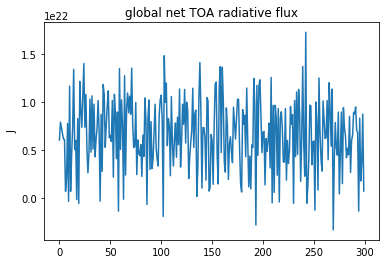

In [112]:
plt.plot(netTOA)
plt.ylabel('J')
plt.title('global net TOA radiative flux')
plt.show()

7. Calculate the cumulative sum

In [113]:
netTOA_cumsum = numpy.cumsum(netTOA)
netTOA_cumsum_anomaly = netTOA_cumsum - netTOA_cumsum[0]

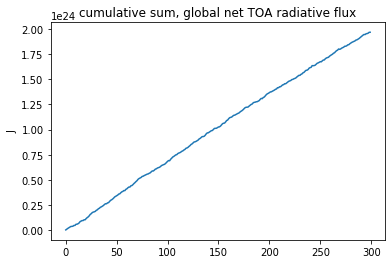

In [116]:
plt.plot(netTOA_cumsum_anomaly)
plt.ylabel('J')
plt.title('cumulative sum, global net TOA radiative flux')
plt.show()

## Ocean heat content

### Temperature

In [117]:
thetaoga_file = '/g/data/p66/CMIP6/APP_publishable/CMIP6/CMIP/CSIRO-ARCCSS-BoM/ACCESS-CM2/piControl/r1i1p1f1/Omon/thetaoga/gn/v20190909/thetaoga_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-124912.nc'

In [118]:
thetaoga_cube = iris.load_cube(thetaoga_file, 'sea_water_potential_temperature')

In [119]:
thetaoga_cube = annual_mean(thetaoga_cube)

In [120]:
thetaoga_cube.data = thetaoga_cube.data + 273.15
thetaoga_cube.units = 'K'

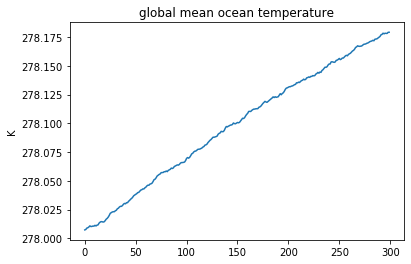

In [121]:
plt.plot(thetaoga_cube.data)
plt.ylabel(thetaoga_cube.units)
plt.title('global mean ocean temperature')
plt.show()

In [122]:
thetaoga_anomaly = thetaoga_cube.data - thetaoga_cube.data[0] 

### Mass

In [123]:
masso_file = '/g/data/p66/CMIP6/APP_publishable/CMIP6/CMIP/CSIRO-ARCCSS-BoM/ACCESS-CM2/piControl/r1i1p1f1/Omon/masso/gn/v20190909/masso_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-124912.nc'

In [124]:
masso_cube = iris.load_cube(masso_file, 'sea_water_mass')

In [125]:
masso_cube = annual_mean(masso_cube)

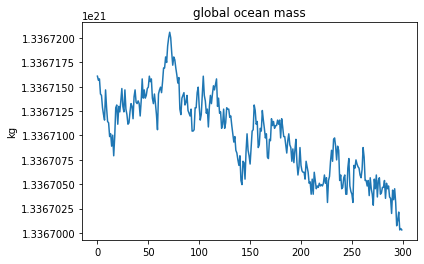

In [126]:
plt.plot(masso_cube.data)
plt.ylabel(masso_cube.units)
plt.title('global ocean mass')
plt.ticklabel_format(useOffset=False)
plt.show()

### OHC

In [127]:
cp = 4000  # J kg-1 K-1

In [128]:
ohc = thetaoga_cube.data * masso_cube.data * cp
ohc_anomaly = ohc - ohc[0]

In [129]:
thermal_ohc = thetaoga_anomaly.data * masso_cube.data[0] * cp
thermal_ohc_anomaly = thermal_ohc - thermal_ohc[0]

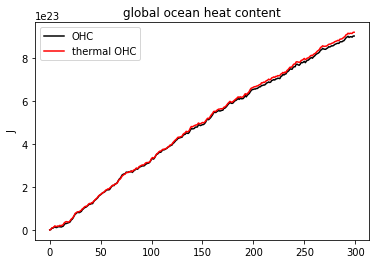

In [130]:
plt.plot(ohc_anomaly, color='black', label='OHC')
plt.plot(thermal_ohc_anomaly, color='red', label='thermal OHC')
plt.ylabel('J')
plt.title('global ocean heat content')
plt.legend()
plt.show()